**Summary:** This project aims to get an overview of the distribution and different characteristics of hydropower plants in Europe, using a dataset from
European Comission's Joint Research Center, publicly available on this Github repository: https://github.com/energy-modelling-toolkit/hydro-power-database/tree/master. We'll get a grisp of the dataset both from a EDA (Exploratory Data Analysis) perspective as well as a clustering approach

The steps taken for this project are the following:

1. Data Importing and Ingestion
2. Data Cleaning and Validation
3. Exploratory Data Analysis
4. Data Pre-processing
5. ML Model Training
6. Model Evaluation
7. Next steps

# Data Importing and Ingestion

In [60]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# importing the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jrc-hydro-power-plant-database.csv')
print(df.head())

      id                                               name  \
0     H1  Grande Dixence - Cleuson-Dixence (chandolin-fi...   
1    H10                                  Chiotas entracque   
2   H100        S.massenza - Vezzano molveno UP_S MASS CL_1   
3  H1000  Lugo di nazza Lugo Di Nazza Hydroelectric Powe...   
4  H1001                                          Pracomune   

   installed_capacity_MW  pumping_MW  type country_code        lat        lon  \
0            2069.000000         NaN  HDAM           CH  46.073100   7.403400   
1            1064.000000      1184.0  HPHS           IT  44.177576   7.416505   
2             377.000000        55.0  HPHS           IT  46.067653  10.983605   
3              38.503185         NaN  HDAM           FR  42.091000   9.316000   
4              42.000000        35.6  HPHS           IT  46.547808  11.007077   

   dam_height_m  volume_Mm3  storage_capacity_MWh  avg_annual_generation_GWh  \
0        1748.0      400.00             1764300.0     

In [62]:
# understanding dataset structure
print(df.shape)
print(df.dtypes)

(4178, 15)
id                            object
name                          object
installed_capacity_MW        float64
pumping_MW                   float64
type                          object
country_code                  object
lat                          float64
lon                          float64
dam_height_m                 float64
volume_Mm3                   float64
storage_capacity_MWh         float64
avg_annual_generation_GWh    float64
pypsa_id                     float64
GEO                          float64
WRI                           object
dtype: object


# Data Cleaning and Validation

On this dataset, we have 4178 rows and 15 columns. We can remove columns pypsa_id, GEO and WRI, because they are foreign keys connecting to other datasets not relevant for the problem at hand. We'll also drop the id and name columns, because they're only unique identifiers that will not be used onward

In [63]:
# dropping columns we'll not use
df = df.drop(['id', 'name', 'pypsa_id', 'GEO', 'WRI'], axis = 1)
df.head()

,installed_capacity_MW,pumping_MW,type,country_code,lat,lon,dam_height_m,volume_Mm3,storage_capacity_MWh,avg_annual_generation_GWh
0,2069.000000,NaN,HDAM,CH,46.073100,7.403400,1748.0,400.00,1764300.0,1400.0
1,1064.000000,1184.0,HPHS,IT,44.177576,7.416505,130.0,30.18,16860.0,NaN
2,377.000000,55.0,HPHS,IT,46.067653,10.983605,580.9,32.70,44800.0,NaN
3,38.503185,NaN,HDAM,FR,42.091000,9.316000,NaN,NaN,NaN,NaN
4,42.000000,35.6,HPHS,IT,46.547808,11.007077,377.0,NaN,NaN,NaN


In [64]:
df.isna().any()

,0
installed_capacity_MW,False
pumping_MW,True
type,False
country_code,False
lat,False
lon,False
dam_height_m,True
volume_Mm3,True
storage_capacity_MWh,True
avg_annual_generation_GWh,True


From the above output, we see that we have missing data on columns:

*   pumping_MW
*   dam_height_m
*   volume_Mm3
*   storage_capacity_MWh
*   avg_annual_generation_GWh

All of these columns, except dam_height_m and avg_annual_generation_GWh, are dependant on the type of hydropower plant. For example, a run-of-river plant will typically have little to no storage capacity. So, for that reason, we expect some missing values in this column. As for the other two columns mentioned before, we'll drop rows with missing values on these features

For the exploratory data analysis step, we will not remove missing values on plant-type dependant columns; however, we'll do that for model training, fitting and evaluation

In [65]:
# dropping rows with NAs for selected columns
df = df.dropna(subset=['dam_height_m', 'avg_annual_generation_GWh'], ignore_index = True)

# Exploratory Data Analysis

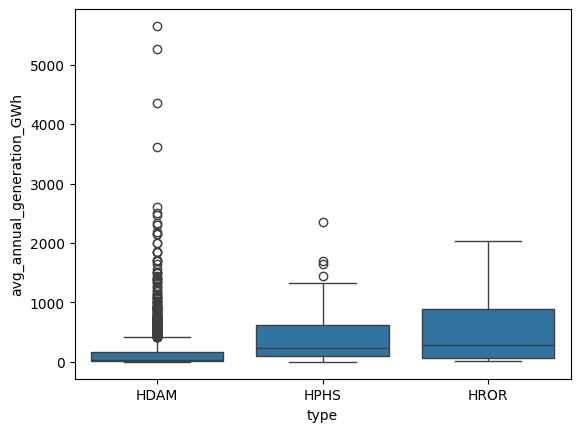

In [66]:
# understanding the distribution of average annual generation within each type of plant
sns.boxplot(data = df, x = 'type', y = 'avg_annual_generation_GWh')
plt.show()

From the graph above, we see that pumped storage-based (HPHS) and run-of-river-based (HROR) tend to generate more energy in general, while storage-based ones (HDAM) tend to generate less, with the exception of the significant number of outliers on this type of power plant

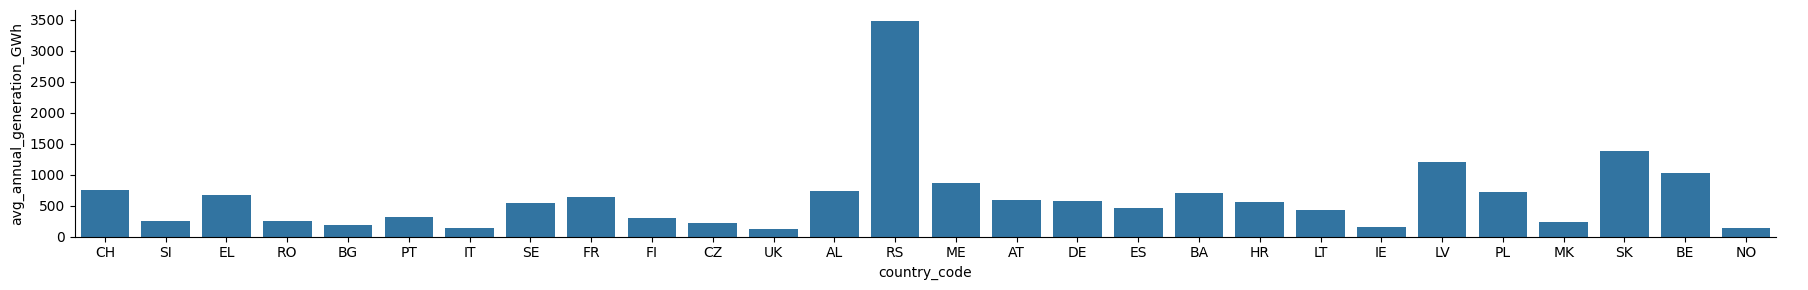

In [67]:
# distribution of average annual generation between countries
sns.catplot(data = df, x = 'country_code', y = 'avg_annual_generation_GWh', estimator = 'mean',
            kind = 'bar', errorbar = None, height = 3, aspect = 6)
plt.show()

From the plot above, we see that Russia (RS) is, by far, the largest country in terms of average annual generation, followed by Slovakia (SK) and Latvia (LV)

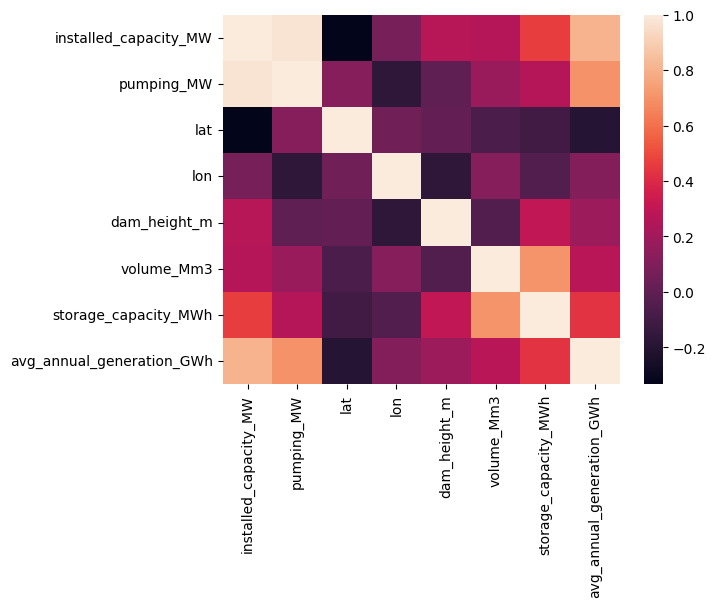

In [68]:
# correlation heatmap
sns.heatmap(data = df.corr(numeric_only = True))
plt.show()

From the correlation heatmap, we identify that installed capacity has a really high correlation with pumping capacity and that installed capacity has a high correlation with average annual generation too

# Data Pre-processing

In [69]:
# drop remaining columns with missing values
df_ml = df.drop(['pumping_MW', 'volume_Mm3', 'storage_capacity_MWh'], axis = 1)

# excluding country code column to remove bias
df_ml = df_ml.drop('country_code', axis = 1)

In [70]:
# one hot encoding for transforming categorical data
df_ml = pd.get_dummies(df_ml, dtype=int)

In [71]:
# normalizing numeric values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_ml[['norm_installed_capacity_MW', 'norm_lat', 'norm_lon', 'norm_dam_height_m', 'norm_avg_annual_generation_GWh']] = \
scaler.fit_transform(df[['installed_capacity_MW', 'lat', 'lon', 'dam_height_m', 'avg_annual_generation_GWh']])

# ML Model Training



Since our primary goal is to understand our data better (and not to make predictions), we'll use a simple K-Means algorithm for this task

In [80]:
from sklearn.cluster import KMeans

# creating a function to identify optimal k
def optimizing_k(data, max_k):
    k_values = []
    sum_squared_dist = []

    for k in range(1, max_k):
        model = KMeans(n_clusters = k, random_state = 1)
        model.fit(data)
        k_values.append(k)
        sum_squared_dist.append(model.inertia_)

# generating elbow plot
    plt.plot(k_values, sum_squared_dist, 'o-')
    plt.show()

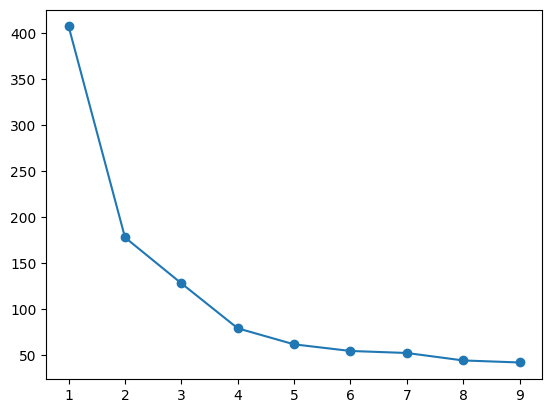

In [81]:
optimizing_k(df_ml.drop(['installed_capacity_MW', 'lat', 'lon', 'dam_height_m', 'avg_annual_generation_GWh'], axis = 1), 10)

Using the elbow plot, we'll use k = 4

In [84]:
# training the model
model = KMeans(n_clusters = 4, random_state = 1)
model.fit(df_ml.drop(['installed_capacity_MW', 'lat', 'lon', 'dam_height_m', 'avg_annual_generation_GWh'], axis = 1))

KMeans(n_clusters=4, random_state=1)

In [85]:
# adding the labels from the model to the original dataframe
df_ml['labels'] = model.labels_
df_ml.head()

,installed_capacity_MW,lat,lon,dam_height_m,avg_annual_generation_GWh,type_HDAM,type_HPHS,type_HROR,norm_installed_capacity_MW,norm_lat,norm_lon,norm_dam_height_m,norm_avg_annual_generation_GWh,labels
0,2069.0,46.073100,7.403400,1748.0,1400.0,1,0,0,1.000000,0.250227,0.405633,1.000000,0.247788,2
1,38.0,46.183870,14.408050,40.0,62.0,1,0,0,0.017892,0.253589,0.584293,0.021848,0.010973,2
2,375.0,40.330500,22.125300,105.0,584.0,1,0,0,0.180851,0.075913,0.781130,0.059073,0.103363,2
3,38.0,44.449583,24.312917,31.0,122.0,1,0,0,0.017892,0.200946,0.836927,0.016694,0.021593,2
4,38.0,45.074583,24.364583,29.0,106.0,1,0,0,0.017892,0.219917,0.838245,0.015548,0.018761,2


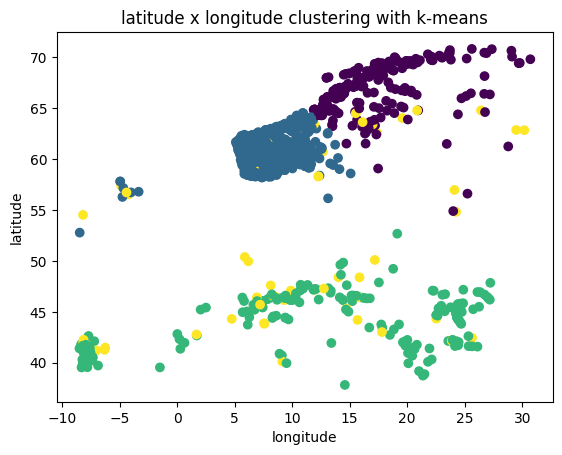

In [86]:
# understanding how the algorithm clustered data in terms of latitude and longitude
plt.scatter(df_ml['lon'], df_ml['lat'], c = df_ml['labels'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('latitude x longitude clustering with k-means')
plt.show()

From the graph above, we see that the model did a decent job in terms of grouping data in all clusters, except the yellow one, indicating that it may be best to use k = 3 instead

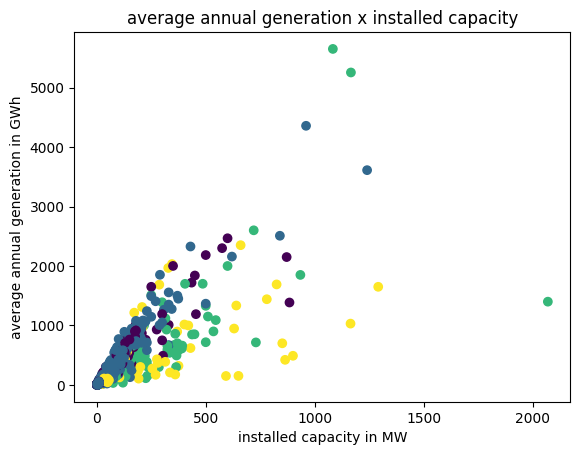

In [87]:
# understanding how the algorithm clustered data in terms of average annual generation and installed capacity
plt.scatter(df_ml['installed_capacity_MW'], df_ml['avg_annual_generation_GWh'], c = df_ml['labels'])
plt.xlabel('installed capacity in MW')
plt.ylabel('average annual generation in GWh')
plt.title('average annual generation x installed capacity')
plt.show()

From the plot above, we conclude that, in this case, the clustering **didn't do** a good job at grouping data :(

# Next steps

To improve our model, some paths to explore are:
*   Train the model with less features or grouping by the type of power plant
*   Using different numbers of cluster
*   Using a different machine learning model, such as DBSCAN



